In [ ]:
import os
import sys
import ctypes

def run_as_admin():
    if sys.platform.startswith('win'):
        app_dir = os.path.dirname(os.path.realpath(sys.argv[0]))
        cmd_args = sys.argv[:]
        cmd_args.insert(0, sys.executable)
        cmd_args = ['"{}"'.format(arg) for arg in cmd_args]
        cmd = '{} -m {}'.format(sys.executable, ' '.join(cmd_args))
        ctypes.windll.shell32.ShellExecuteW(None, "runas", cmd, None, app_dir, 1)

if __name__ == '__main__':
    run_as_admin()


In [17]:
# import libraries
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from PIL import Image
import shutil
import random
import matplotlib.pyplot as plt
import glob
from tensorflow.keras import layers
from tensorflow.keras import metrics
from tensorflow.keras.metrics import Precision, Recall
from keras.metrics import Metric
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE


In [ ]:
# Path to data folder
data_dir = os.path.join(os.getcwd(), 'Brain Tumor MRI')

# Path to processed data
output_dir = os.path.join(os.getcwd(), 'Processed Data')

In [ ]:
# check if folder was created
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [ ]:
# Iteration by data in folder
for dir_name in os.listdir(data_dir):
    # Create path to folder with images
    dir_path = os.path.join(data_dir, dir_name)
    #Check if item is folder or hidden file
    if os.path.isdir(dir_path) and not dir_name.startswith("."):
        print(f"Processing images in {dir_name}...")
        #Create path to output directory for such type of images
        output_path = os.path.join(output_dir, dir_name)
        if not os.path.exists(output_path):
            os.makedirs(output_path)
        # Iteration by files in folder
        for filename in os.listdir(dir_path):
            # Check if file is mage
            if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
                # Load file, initial processing
                img_path = os.path.join(dir_path, filename)
                with Image.open(img_path) as img:
                    img = img.rotate(90)
                    # Save processed image
                    output_filename = os.path.join(output_path, filename)
                    img.save(output_filename)

In [ ]:
# Input data dimensions
IMG_HEIGHT = 256
IMG_WIDTH = 256

# Initial pre processing
for folder_name in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder_name)
    if os.path.isdir(folder_path):
        print(f'Preprocessing of {folder_name}')
        output_folder_path = os.path.join(output_dir, folder_name)
        if not os.path.exists(output_folder_path):
            os.makedirs(output_folder_path)
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.jpg'):
                file_path = os.path.join(folder_path, file_name)
                img = cv2.imread(file_path, cv2.IMREAD_COLOR)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
                img = img / 255.0
                output_file_path = os.path.join(output_folder_path, file_name)
                cv2.imwrite(output_file_path, img * 255.0)

## EDA for training set

In [ ]:
# Path to Processed Data
processed_data_path = os.path.join(os.getcwd(), 'Processed Data')

# Paths to train/test and validation sets
train_path = os.path.join(processed_data_path, "train")
val_path = os.path.join(processed_data_path, "validation")
test_path = os.path.join(processed_data_path, "test")

# Split for train/ test and validation sets
train_split = 0.6
test_split = 0.2
val_split = 0.2

# Train, test, validation for paths in processed data
for folder_name in os.listdir(processed_data_path):
    folder_path = os.path.join(processed_data_path, folder_name)
    if os.path.isdir(folder_path):
        train_folder_path = os.path.join(train_path, folder_name)
        val_folder_path = os.path.join(val_path, folder_name)
        test_folder_path = os.path.join(test_path, folder_name)
        os.makedirs(train_folder_path, exist_ok=True)
        os.makedirs(val_folder_path, exist_ok=True)
        os.makedirs(test_folder_path, exist_ok=True)
        
        # List of files and random order
        files = os.listdir(folder_path)
        random.shuffle(files)
        
        
        train_files = files[:int(train_split * len(files))]
        val_files = files[int(train_split * len(files)):int((train_split + val_split) * len(files))]
        test_files = files[int((train_split + val_split) * len(files)):]
        for file_name in train_files:
            src_path = os.path.join(folder_path, file_name)
            dst_path = os.path.join(train_folder_path, file_name)
            shutil.copy(src_path, dst_path)
        for file_name in val_files:
            src_path = os.path.join(folder_path, file_name)
            dst_path = os.path.join(val_folder_path, file_name)
            shutil.copy(src_path, dst_path)
        for file_name in test_files:
            src_path = os.path.join(folder_path, file_name)
            dst_path = os.path.join(test_folder_path, file_name)
            shutil.copy(src_path, dst_path)


In [18]:
# Data check
train_path = os.path.join("Processed Data", "train")

# 
classes = []
num_images = []
dimensions = []
pixel_means = []


for class_name in os.listdir(train_path):
    class_path = os.path.join(train_path, class_name)
    if os.path.isdir(class_path):
        classes.append(class_name)
        
        class_num_images = 0
        
        class_dimensions = []
        
        class_pixel_means = []
        
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            if os.path.isfile(image_path):
                image = plt.imread(image_path)
                height, width = image.shape[:2]
                class_dimensions.append((height, width))
                
                pixel_mean = image.mean()
                class_pixel_means.append(pixel_mean)
                
                class_num_images += 1
        
        num_images.append(class_num_images)
        
        class_avg_height = sum([dim[0] for dim in class_dimensions]) / class_num_images
        class_avg_width = sum([dim[1] for dim in class_dimensions]) / class_num_images
        class_avg_dimension = (class_avg_height, class_avg_width)
        dimensions.append(class_avg_dimension)
        
        class_avg_pixel_mean = sum(class_pixel_means) / class_num_images
        pixel_means.append(class_avg_pixel_mean)

for i, class_name in enumerate(classes):
    print(f"Class {i + 1}: {class_name}")
    print(f"Number of images: {num_images[i]}")
    print(f"Average dimensions: {dimensions[i]}")
    print(f"Average pixel mean: {pixel_means[i]}")
    print()

Class 1: Astrocitoma T1
Number of images: 105
Average dimensions: (522.6857142857143, 514.6952380952381)
Average pixel mean: 42.95838607456881

Class 2: Astrocitoma T1C+
Number of images: 139
Average dimensions: (554.5611510791367, 552.2158273381295)
Average pixel mean: 43.61071428274967

Class 3: Astrocitoma T2
Number of images: 102
Average dimensions: (540.3333333333334, 518.1862745098039)
Average pixel mean: 44.41717035197188

Class 4: Carcinoma T1
Number of images: 39
Average dimensions: (601.2307692307693, 531.0769230769231)
Average pixel mean: 73.59633759873034

Class 5: Carcinoma T1C+
Number of images: 66
Average dimensions: (613.0, 539.9545454545455)
Average pixel mean: 58.366109188614175

Class 6: Carcinoma T2
Number of images: 43
Average dimensions: (569.1162790697674, 504.13953488372096)
Average pixel mean: 38.7277663478673

Class 7: Ependimoma T1
Number of images: 27
Average dimensions: (602.2962962962963, 571.6666666666666)
Average pixel mean: 44.093038381700744

Class 8: 

In [ ]:
# Chart creation
fig, ax = plt.subplots(figsize=(24, 16))
ax.bar(classes, num_images, width=0.5)

# Labels
ax.set_ylabel('Mean no. of images', fontsize=14)
ax.set_title('Mean number of images per class in training set', fontsize=16)

# Axis details
ax.set_xticklabels(classes, rotation=45, ha='right')

# Font
plt.rcParams.update({'font.size': 12})

# Chart show
plt.show()

In [ ]:
# Chart creation
fig, ax = plt.subplots(figsize=(24, 16))
ax.bar(classes, num_images, width=0.5)

# Labels
ax.set_ylabel('Mean no. of images', fontsize=14)
ax.set_title('Mean number of images per class in training set', fontsize=16)

# Axis details
ax.set_xticklabels(classes, rotation=45, ha='right')

# Font
plt.rcParams.update({'font.size': 12})

# Chart show
plt.show()

In [ ]:
# Tuple unpacking
x = range(len(classes))
y1 = [t[0] for t in dimensions]  # wymiar x
y2 = [t[1] for t in dimensions]  # wymiar y

# Chart creation
fig, ax = plt.subplots(figsize=(24, 16))
ax.bar(x, y1, width=0.4, align='center', label='Wymiar x')
ax.bar([i+0.4 for i in x], y2, width=0.4, align='center', label='Wymiar y')

# Axis details
ax.set_xticklabels(classes, rotation=45, ha='right')

# Title and lables
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.set_ylabel('Average dimensions', fontsize=14)
ax.set_title('Avergae dimensions per class', fontsize=16)
ax.legend()

# Font
plt.rcParams.update({'font.size': 12})

# Chart
plt.show()

In [19]:
class_dict = {class_name: str(i) for i, class_name in enumerate(classes)}

In [20]:
# ustaw ścieżkę do katalogu z obrazami
train_path = os.path.join("Processed Data", "train")

# utwórz pustą tablicę X_train i listę y_train
X_train = []
y_train = []

# przejdź przez katalog i wczytaj każdy obraz
for root, dirs, files in os.walk(train_path):
    for filename in files:
        if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png') or filename.endswith('.bmp'):
            # wczytaj obraz i przetwórz go
            img = cv2.imread(os.path.join(root, filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224, 224)) # przykładowy rozmiar
            X_train.append(img)

            # wczytaj etykietę z nazwy katalogu i dodaj do listy y_train
            label = class_dict[root.split(os.path.sep)[-1]]
            y_train.append(label)

# przekształć listy w tablice numpy
X_train = np.array(X_train)
y_train = np.array(y_train)



In [21]:
print(X_train.shape)
print(y_train.shape)

(2659, 224, 224, 3)
(2659,)


In [8]:
# ustaw ścieżkę do katalogu z obrazami
validation_path = os.path.join("Processed Data", "validation")

# utwórz pustą tablicę X_train i listę y_train
X_val = []
y_val = []

# przejdź przez katalog i wczytaj każdy obraz
for root, dirs, files in os.walk(validation_path):
    for filename in files:
        if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png') or filename.endswith('.bmp'):
            # wczytaj obraz i przetwórz go
            img = cv2.imread(os.path.join(root, filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224, 224)) # przykładowy rozmiar
            X_val.append(img)

            # wczytaj etykietę z nazwy katalogu i dodaj do listy y_train
            label = class_dict[root.split(os.path.sep)[-1]]
            y_val.append(label)

# przekształć listy w tablice numpy
X_val = np.array(X_val)
y_val = np.array(y_val)

print(X_val.shape)
print(y_val.shape)

(894, 224, 224, 3)
(894,)


In [9]:
# ustaw ścieżkę do katalogu z obrazami
test_path = os.path.join("Processed Data", "test")

# utwórz pustą tablicę X_train i listę y_train
X_test = []
y_test = []

# przejdź przez katalog i wczytaj każdy obraz
for root, dirs, files in os.walk(test_path):
    for filename in files:
        if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png') or filename.endswith('.bmp'):
            # wczytaj obraz i przetwórz go
            img = cv2.imread(os.path.join(root, filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224, 224)) # przykładowy rozmiar
            X_test.append(img)

            # wczytaj etykietę z nazwy katalogu i dodaj do listy y_train
            label = class_dict[root.split(os.path.sep)[-1]]
            y_test.append(label)

# przekształć listy w tablice numpy
X_test = np.array(X_test)
y_test = np.array(y_test)

print(X_test.shape)
print(y_test.shape)

(912, 224, 224, 3)
(912,)


## Althought I know that data is imbalanced, let's start with base model for reference

In [156]:
#y_train = to_categorical(y_train, num_classes=44)
#y_val =  to_categorical(y_val, num_classes=44)
#y_test = to_categorical(y_test, num_classes=44)

In [10]:
print(X_val.shape)
print(y_val.shape)

(894, 224, 224, 3)
(894,)


In [158]:
#definition of architecture of model
model = Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(44, activation='softmax')
])

In [166]:
#metrics
class F1Score(Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)
        precision = self.precision.result()
        recall = self.recall.result()
        f1_score = 2 * ((precision * recall) / (precision + recall + 1e-7))
        self.f1_score = f1_score
        
    def result(self):
        return self.f1_score
        
    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()
        self.f1_score = 0.0

In [173]:
#model compilation
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall(), F1Score()])


In [174]:
#training
history = model.fit(X_train, y_train, epochs=10, batch_size=32,
                    validation_data=(X_val, y_val))


Epoch 1/10
84/84 [==============================] - ETA: 0s - loss: 16.1626 - accuracy: 0.1662 - precision_10: 0.2782 - recall_8: 0.0278 - f1_score: 0.0506

c:\Users\andrz\Anaconda3\lib\site-packages\keras\engine\training.py:2034: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


84/84 [==============================] - 92s 1s/step - loss: 16.1626 - accuracy: 0.1662 - precision_10: 0.2782 - recall_8: 0.0278 - f1_score: 0.0506 - val_loss: 2.4888 - val_accuracy: 0.3736 - val_precision_10: 0.8641 - val_recall_8: 0.0996 - val_f1_score: 0.1785
Epoch 2/10
84/84 [==============================] - 88s 1s/step - loss: 1.8521 - accuracy: 0.5359 - precision_10: 0.8465 - recall_8: 0.3381 - f1_score: 0.4832 - val_loss: 1.7277 - val_accuracy: 0.5940 - val_precision_10: 0.8112 - val_recall_8: 0.5045 - val_f1_score: 0.6221
Epoch 3/10
84/84 [==============================] - 85s 1s/step - loss: 0.9625 - accuracy: 0.7330 - precision_10: 0.8758 - recall_8: 0.6363 - f1_score: 0.7371 - val_loss: 1.6345 - val_accuracy: 0.6432 - val_precision_10: 0.7740 - val_recall_8: 0.5671 - val_f1_score: 0.6546
Epoch 4/10
84/84 [==============================] - 85s 1s/step - loss: 0.5681 - accuracy: 0.8499 - precision_10: 0.9243 - recall_8: 0.7947 - f1_score: 0.8546 - val_loss: 1.4152 - val_accu

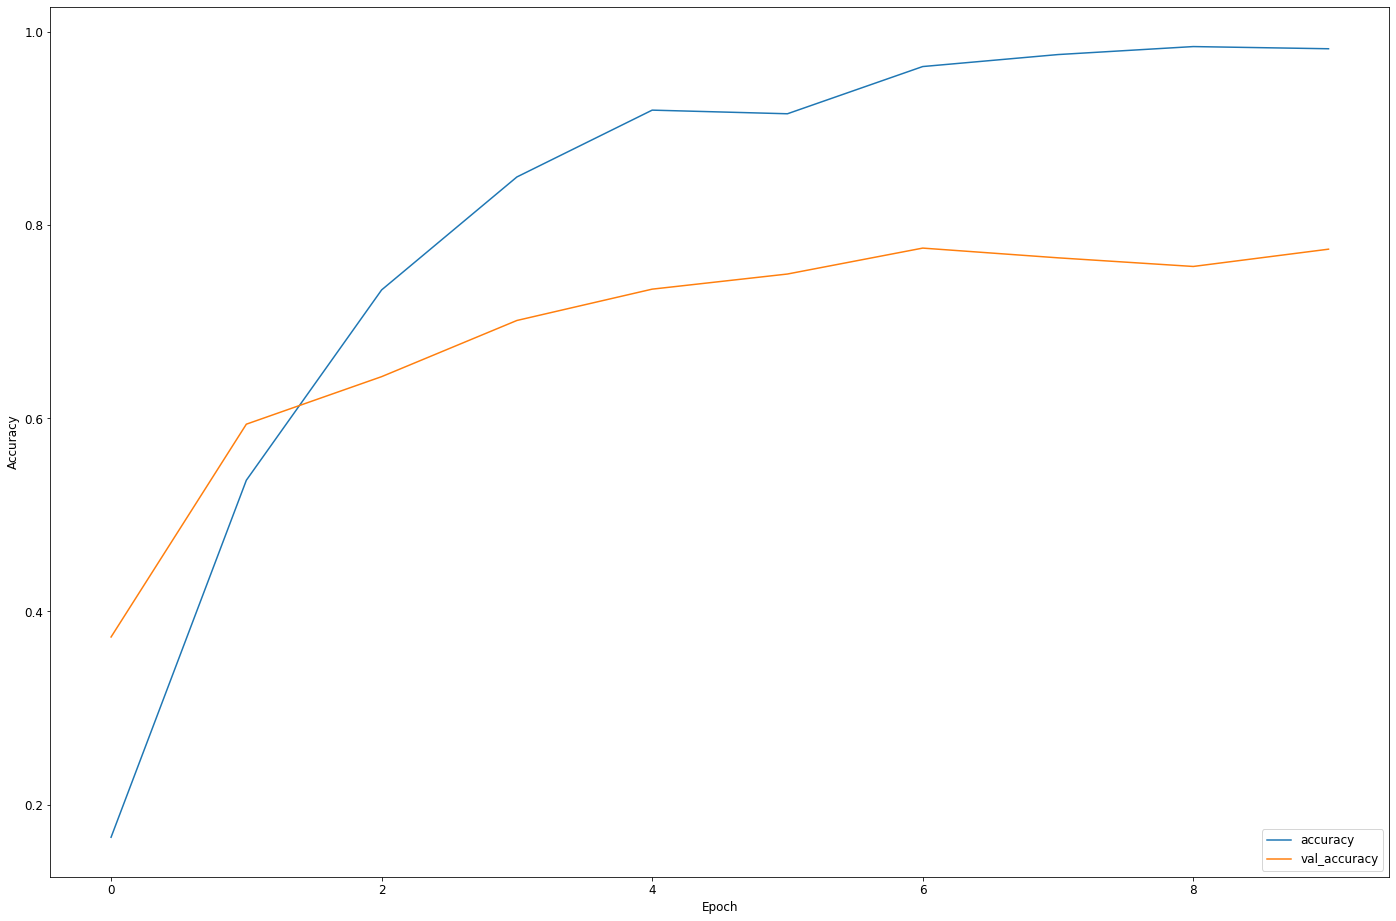

In [176]:
fig, ax = plt.subplots(figsize=(24, 16))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


In [179]:
test_loss, test_acc, test_precision, test_recall, test_f1_score = model.evaluate(X_test, y_test)



28/28 [==============================] - 6s 218ms/step - loss: 1.5746 - accuracy: 0.7752 - precision_10: 0.8057 - recall_8: 0.7651 - f1_score: 0.7849


In [180]:
# Uzyskanie predykcji dla zbioru testowego
y_pred = model.predict(X_test)

# Konwersja predykcji i rzeczywistych etykiet na wartości binarne
y_pred_binary = np.argmax(y_pred, axis=1)
y_test_binary = np.argmax(y_test, axis=1)

# Wyświetlenie raportu klasyfikacji
print(classification_report(y_test_binary, y_pred_binary))


              precision    recall  f1-score   support

           0       0.59      0.77      0.67        35
           1       0.72      0.67      0.70        46
           2       0.71      0.71      0.71        34
           3       0.92      0.92      0.92        13
           4       1.00      0.91      0.95        22
           5       1.00      0.86      0.92        14
           6       0.64      0.78      0.70         9
           7       1.00      0.30      0.46        10
           8       0.71      0.45      0.56        11
           9       0.40      0.50      0.44         4
          10       0.40      0.50      0.44         4
          11       1.00      0.20      0.33         5
          12       0.75      0.60      0.67         5
          13       0.60      0.86      0.71         7
          14       1.00      0.67      0.80         6
          15       0.88      0.64      0.74        11
          16       0.81      0.89      0.85        19
          17       0.73    

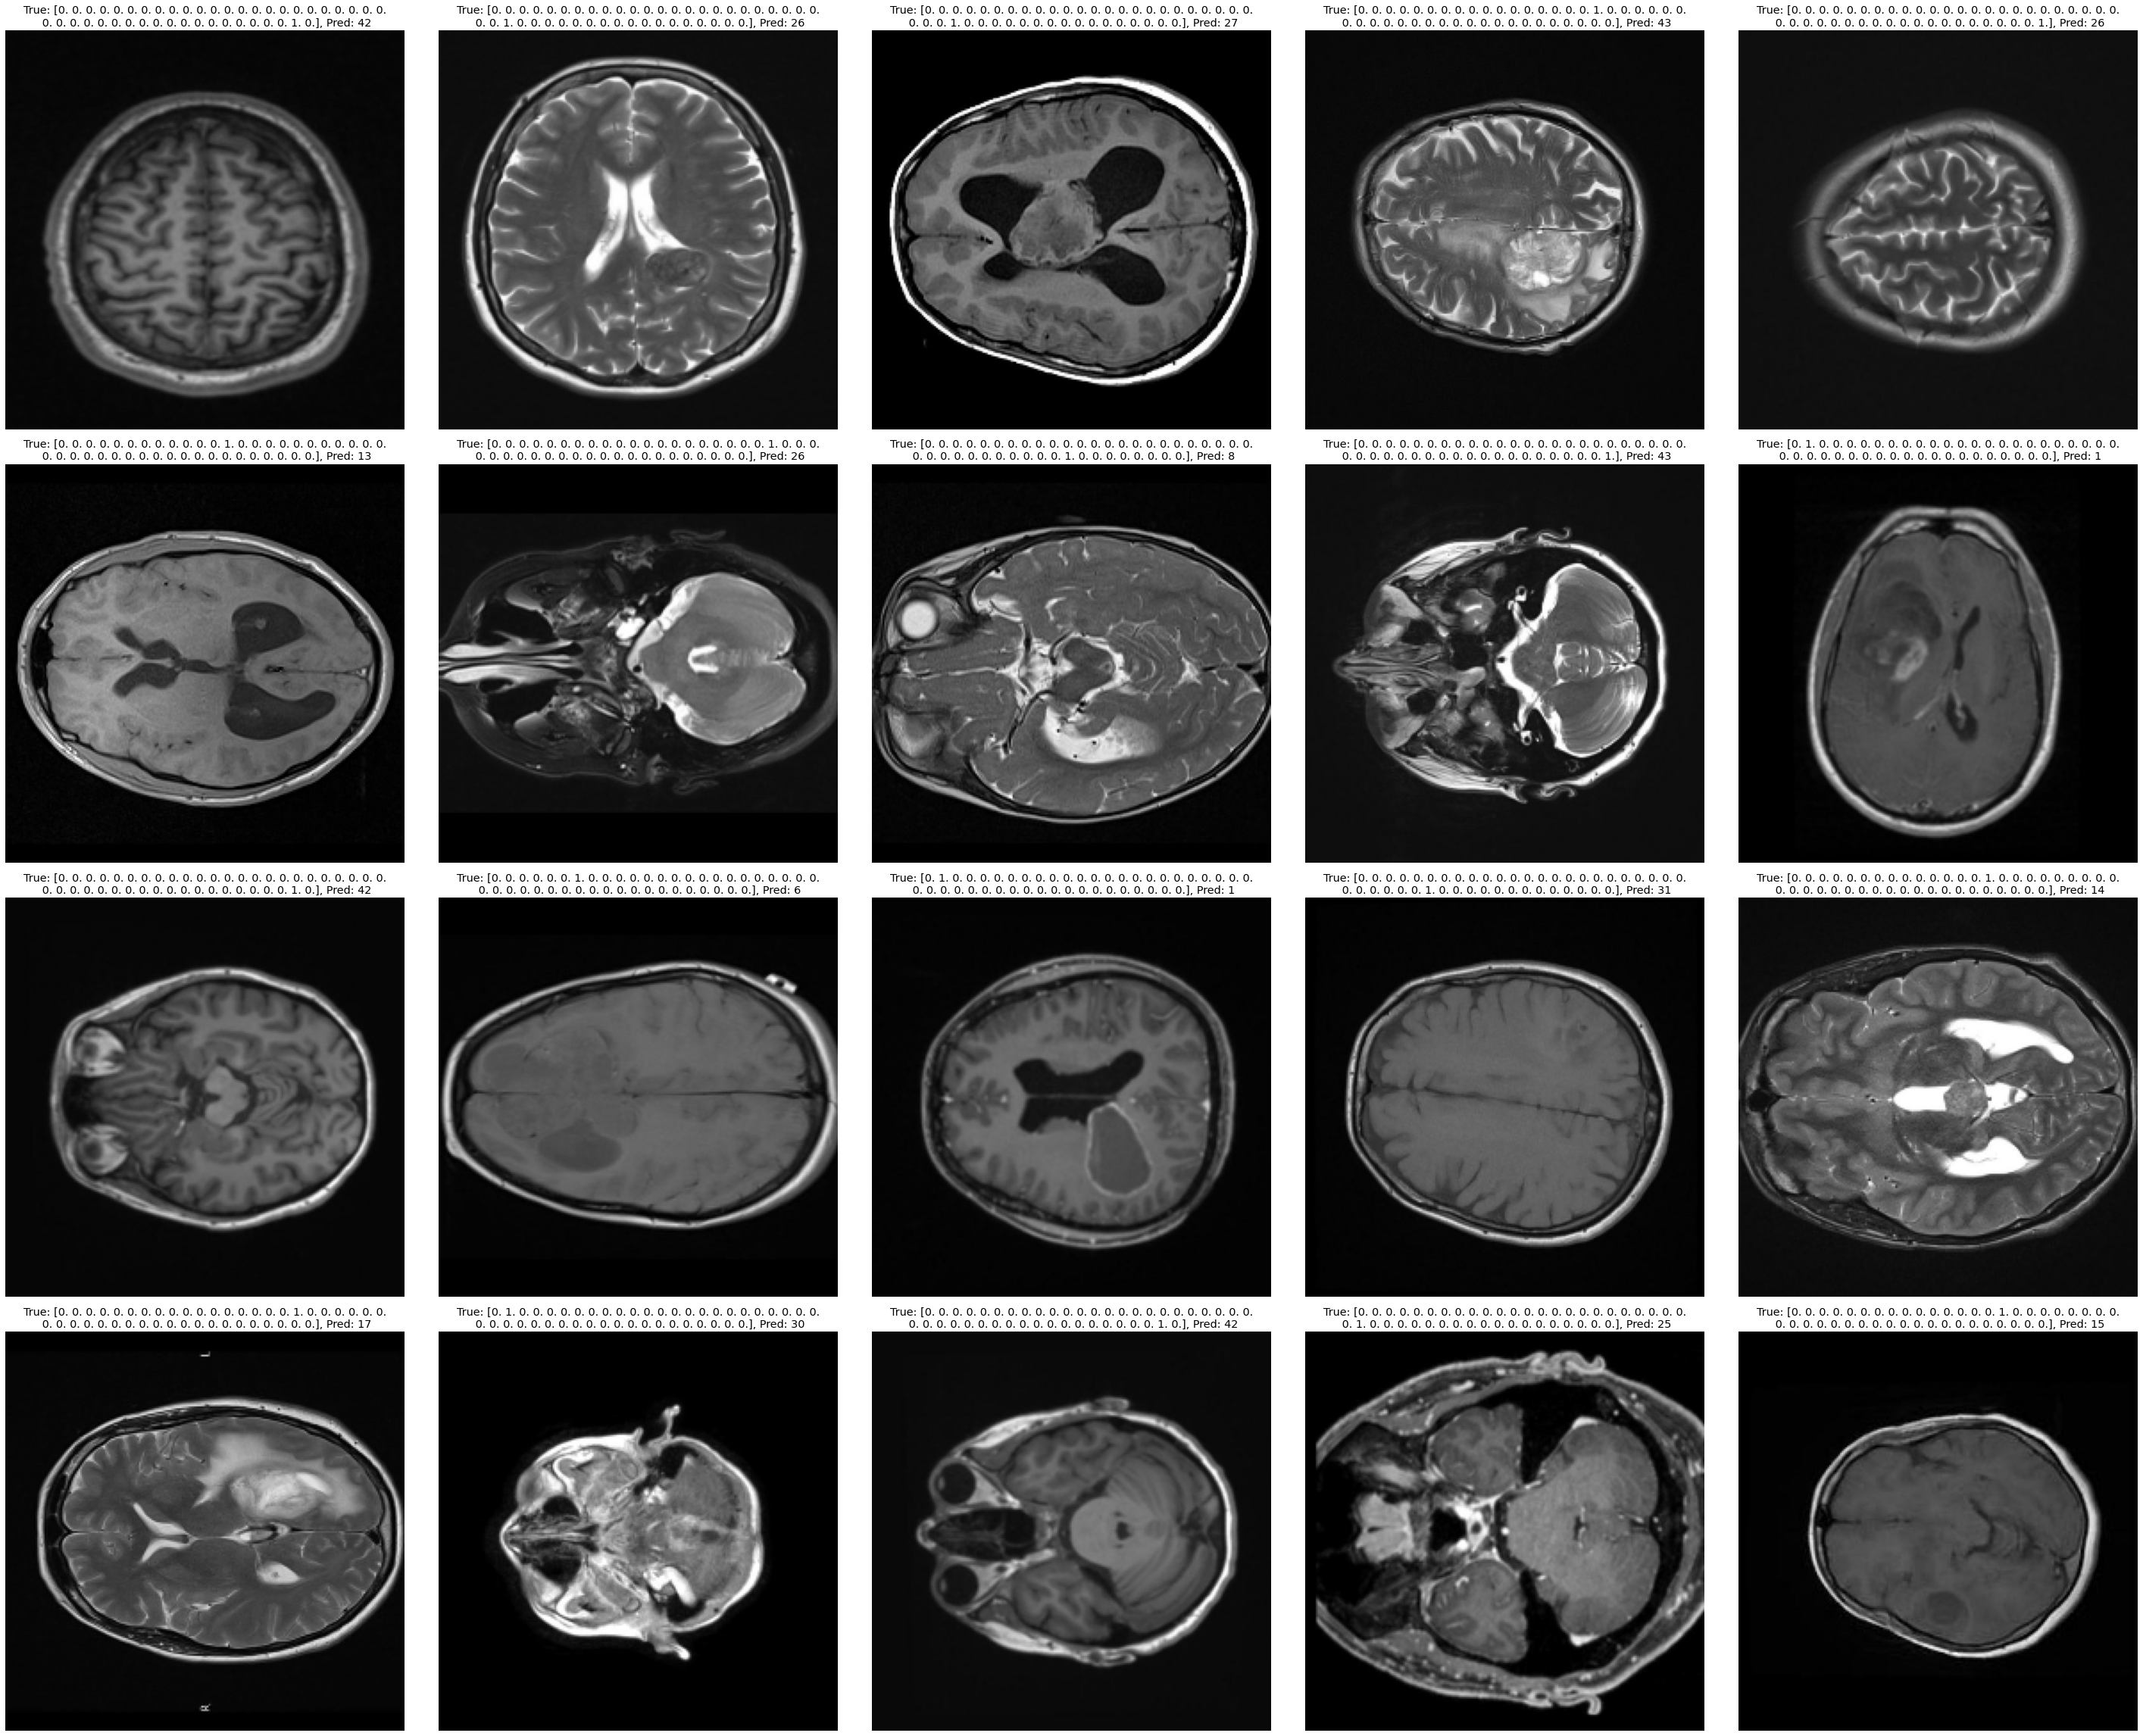

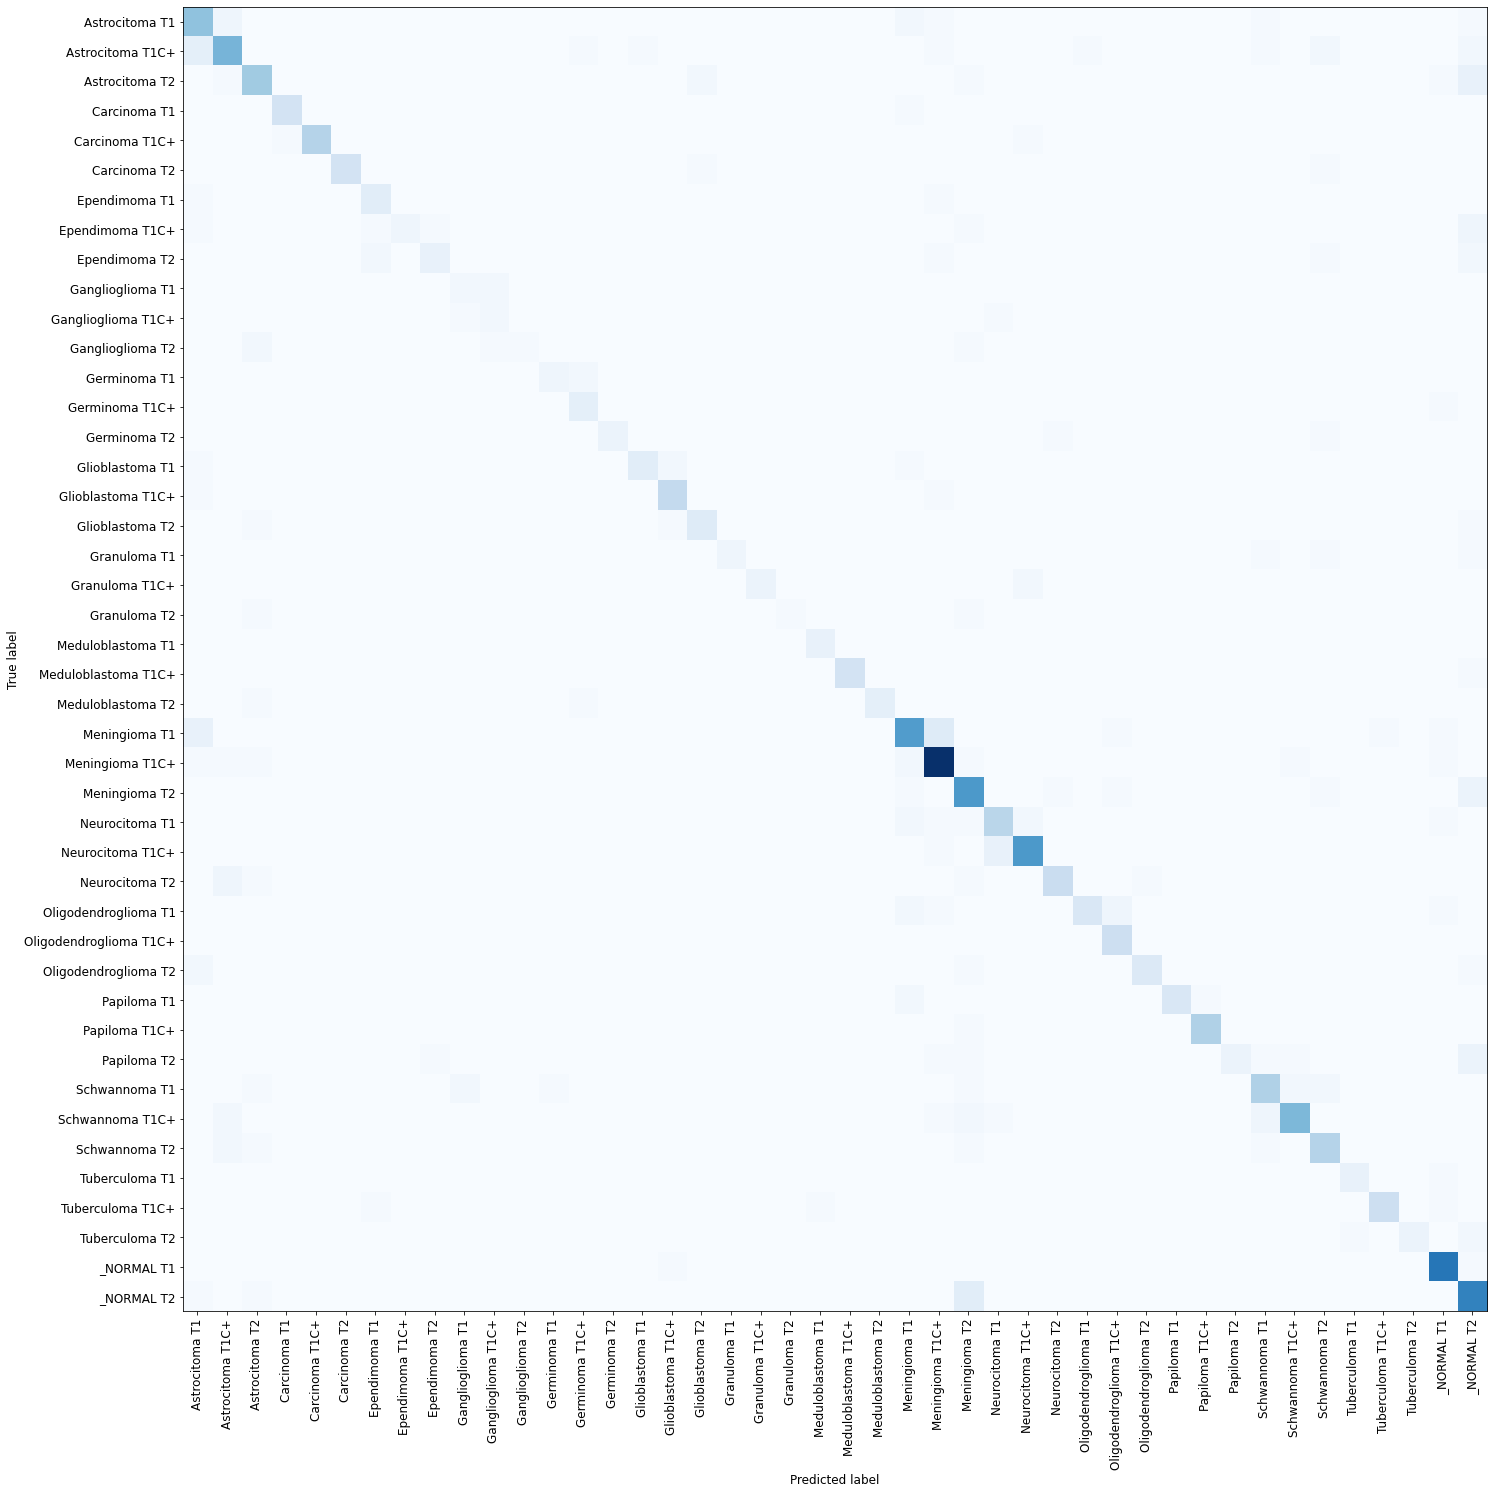

In [188]:
# Przygotowanie losowych przykładów ze zbioru testowego
num_examples = 20
random_indexes = np.random.choice(len(X_test), size=num_examples, replace=False)
X_examples = X_test[random_indexes]
y_true_examples = y_test[random_indexes]

# Predykcja klas dla losowych przykładów
y_pred_examples = model.predict(X_examples)

# Wizualizacja losowych przykładów wraz z prawdziwymi etykietami i predykcjami modelu
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(40, 32))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_examples[i])
    ax.axis('off')
    ax.set_title(f"True: {y_true_examples[i]}, Pred: {np.argmax(y_pred_examples[i])}")
plt.tight_layout()

# Macierz konfuzji dla zbioru testowego
from sklearn.metrics import confusion_matrix

y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

# Wizualizacja macierzy konfuzji
fig, ax = plt.subplots(figsize=(32, 24))
ax.imshow(cm, cmap='Blues')

ax.set_xticks(range(len(classes)))
ax.set_xticklabels(classes, rotation=90)
ax.set_yticks(range(len(classes)))
ax.set_yticklabels(classes)
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')
plt.show()


## Oversampling

In [22]:
# Przekształcenie danych na format 2D - tablica z wymiarem próbek i cech
X_train_flat = X_train.reshape(X_train.shape[0], -1)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_flat, y_train)




In [23]:
X_resampled = X_resampled.reshape(-1, 224, 224, 3)

In [24]:
from collections import Counter

# Wyświetlenie liczby próbek w klasach przed oversamplingiem
print('Liczba próbek przed oversamplingiem:')
print(Counter(y_train))


# Wyświetlenie liczby próbek w klasach po oversamplingiem
print('\nLiczba próbek po oversamplingiem:')
print(Counter(y_resampled))


Liczba próbek przed oversamplingiem:
Counter({'25': 221, '24': 163, '43': 162, '42': 150, '1': 139, '26': 139, '28': 133, '37': 116, '0': 105, '2': 102, '36': 88, '27': 78, '38': 73, '4': 66, '34': 64, '29': 62, '16': 56, '30': 51, '40': 50, '5': 43, '31': 43, '22': 40, '3': 39, '32': 39, '33': 39, '35': 37, '8': 34, '15': 33, '17': 33, '7': 28, '6': 27, '23': 24, '13': 21, '41': 19, '18': 18, '19': 18, '12': 16, '14': 16, '39': 16, '11': 13, '21': 13, '9': 12, '10': 10, '20': 10})

Liczba próbek po oversamplingiem:
Counter({'0': 221, '1': 221, '2': 221, '3': 221, '4': 221, '5': 221, '6': 221, '7': 221, '8': 221, '9': 221, '10': 221, '11': 221, '12': 221, '13': 221, '14': 221, '15': 221, '16': 221, '17': 221, '18': 221, '19': 221, '20': 221, '21': 221, '22': 221, '23': 221, '24': 221, '25': 221, '26': 221, '27': 221, '28': 221, '29': 221, '30': 221, '31': 221, '32': 221, '33': 221, '34': 221, '35': 221, '36': 221, '37': 221, '38': 221, '39': 221, '40': 221, '41': 221, '42': 221, '43': 